 # Imports

In [1]:
#standard pytorch modules
import torch #holds all the things required for tensor computation
import torch.nn as nn #provides classes and functions to build nn
import torch.nn.functional as F
import torch.optim as optim #for optimizers like ADAM etc
from torch.utils.tensorboard import SummaryWriter #generates report for tensor board
from torch.autograd import Variable
#import torchvision module to handle image manipulation
import torchvision #has datasets, model architectures # image transforma for CV
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

#calculate train time , writing train data to files etc.
import time
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from IPython.display import clear_output

torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)
from sklearn.metrics import confusion_matrix
import torchvision.datasets as datasets

#▶Load data

In [2]:
test_set=datasets.FashionMNIST(
    train=False,
    root='./data',
    download=True,
    transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,),)])
)

train_set=datasets.FashionMNIST(
    train=True,
    root='./data',
    download=True,
    transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,),)])
)


100%|██████████| 26421880/26421880 [00:00<00:00, 116907483.66it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 7146272.73it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 61701857.64it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 11602513.16it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [3]:
from torch.utils.data.sampler import SubsetRandomSampler
  #preparing validation set
indices=list(range(len(train_set)))
np.random.shuffle(indices)
split=int(np.floor(0.2*len(train_set)))
train_sample=SubsetRandomSampler(indices[:split])
valid_sample=SubsetRandomSampler(indices[split:])

train_loader=torch.utils.data.DataLoader(train_set,sampler=train_sample,batch_size=64)
valid_loader=torch.utils.data.DataLoader(train_set,sampler=train_sample,batch_size=32)
testloader=torch.utils.data.DataLoader(test_set,batch_size=64,shuffle=True)

#▶Vizualize the data

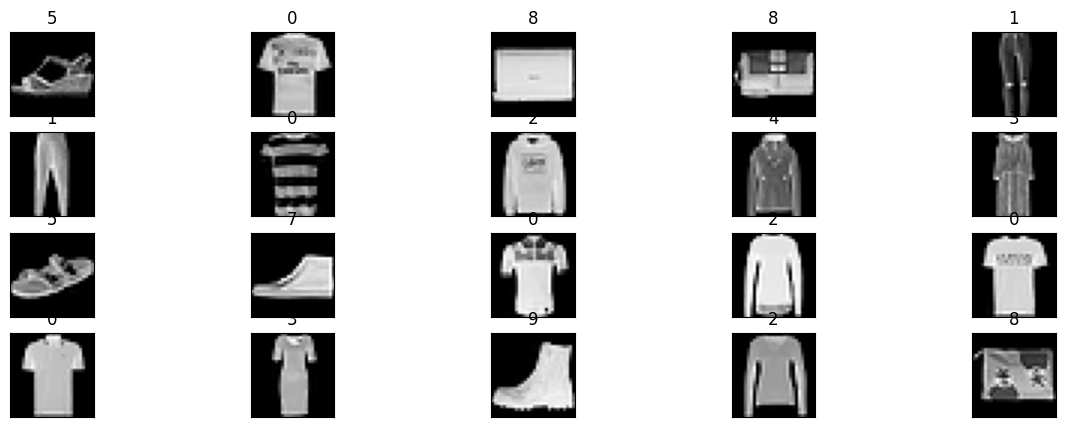

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

dataiter = iter(train_loader)
print(dataiter)
images,labels=next(dataiter)

fig=plt.figure(figsize=(15,5))
for idx in np.arange(20):
  ax=fig.add_subplot(4,(int(20/4)),idx+1,xticks=[],yticks=[])
  ax.imshow(np.squeeze(images[idx]),cmap='gray')
  ax.set_title(labels[idx].item())
  fig.tight_layout

#▶Building the neural network

In [5]:
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1=nn.Linear(784,256)
    self.fc2=nn.Linear(256,100)
    self.fc3=nn.Linear(100,64)
    self.fc4=nn.Linear(64,10)
    #defining the 20% dropout
    self.dropout=nn.Dropout(0.2)

  def forward(self,x):
    x=x.view(x.size(0),-1)
    x=self.dropout(F.relu(self.fc1(x)))
    x=self.dropout(F.relu(self.fc2(x)))
    x=self.dropout(F.relu(self.fc3(x)))
    #not using dropout on output layer
    x=F.log_softmax(self.fc4(x),dim=1)
    return x

#▶Training the model

In [6]:
model=Classifier()
#defining the loss function
criterion=nn.NLLLoss()
optimizer=optim.SGD(model.parameters(),lr=0.01)

valid_loss_min=np.Inf
epochs=40
steps=0
model.train()
train_losses,valid_losses=[],[]
for e in range(epochs):
  running_loss=0
  valid_loss=0
  #train the model
  for images,labels in train_loader:

    optimizer.zero_grad()
    log_ps=model(images)
    loss=criterion(log_ps,labels)
    loss.backward()
    optimizer.step()
    running_loss+=loss.item()*images.size(0)

  for image,labels in valid_loader:
    log_ps=model(images)
    loss=criterion(log_ps,labels)
    valid_loss+=loss.item()*images.size(0)

  running_loss=running_loss/len(train_loader.sampler)
  valid_loss=valid_loss/len(valid_loader.sampler)
  train_losses.append(running_loss)
  valid_losses.append(valid_loss)

  print(e+1,running_loss,valid_loss)
  if valid_loss<=valid_loss_min:
    torch.save(model.state_dict(),'model.pt')
    valid_loss_min=valid_loss


1 2.259121612548828 2.3130242722829184
2 1.9036062647501628 2.959914886474609
3 1.3811153682072956 4.074372771581014
4 1.1367844616572063 4.842157501856486
5 1.0023227893511455 5.4778200651804605
6 0.9121713892618815 5.404801312764485
7 0.8404813241958619 5.986094938913981
8 0.7778088757197062 6.057633876800537
9 0.7340053938229879 6.772681434631347
10 0.7089993643760681 5.801563800811768
11 0.6809922388394674 6.770236525217692
12 0.6638927467664083 6.454637409210205
13 0.6507074858347575 6.213101844151815
14 0.6243847764333089 6.563252304077149
15 0.6072567340532938 6.563645543416341
16 0.5962878966331482 6.840388800303141
17 0.5818916403452555 7.0755215263366695
18 0.571035351117452 6.701180342356364
19 0.5534696466128032 6.303085783640544
20 0.5534259394804637 6.999622276306153
21 0.535736973285675 6.79897343826294
22 0.5214814794858297 7.162858098347982
23 0.5197593469619751 7.958624838511149
24 0.504343725045522 7.798713790893554
25 0.49678002150853473 8.271205801645914
26 0.49020

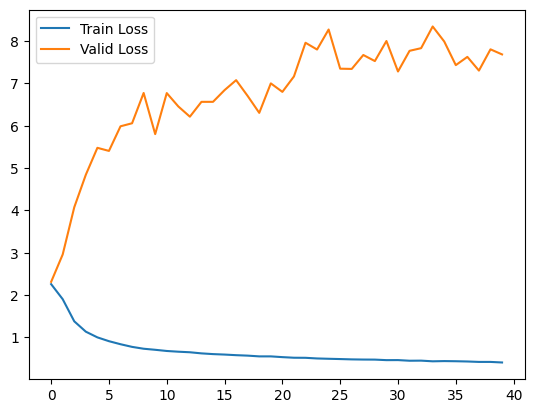

In [7]:
plt.plot(train_losses,label='Train Loss')
plt.plot(valid_losses,label='Valid Loss')

plt.legend()

#▶Testing the model

In [8]:
#track the test loss
test_loss=0
class_correct=list(0. for i in range(10))
class_total=list(0. for i in range(10))

model.eval()
for images,labels in testloader:
  #forward pass
  output=model(images)
  #calculate the loss
  loss=criterion(output,labels)
  #update the test loss
  test_loss+=loss.item()*images.size(0)
  #convert output probabilities to predicted class
  _, pred=torch.max(output,1)
  #compare predictions to true labels
  correct=np.squeeze(pred.eq(labels.data.view_as(pred)))
  #calculate test accuracy for each object class
  for i in range(len(labels)):
    label=labels.data[i]
    class_correct[label]+=correct[i].item()
    class_total[label]+=1

#calculate and print test loss
test_loss=test_loss/len(testloader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
  if class_total[i]>0:
    print('Test Accuracy of %5s: %2d%% (%2d/%2d)'%(str(i),100*class_correct[i]/class_total[i],
                                                   np.sum(class_correct[i]),np.sum(class_total[i])))
  
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)'%(100. *np.sum(class_correct)/np.sum(class_total),
                                                    np.sum(class_correct),np.sum(class_total)))

Test Loss: 0.444119

Test Accuracy of     0: 84% (847/1000)
Test Accuracy of     1: 95% (956/1000)
Test Accuracy of     2: 71% (715/1000)
Test Accuracy of     3: 83% (830/1000)
Test Accuracy of     4: 78% (783/1000)
Test Accuracy of     5: 88% (884/1000)
Test Accuracy of     6: 53% (530/1000)
Test Accuracy of     7: 92% (923/1000)
Test Accuracy of     8: 96% (961/1000)
Test Accuracy of     9: 94% (942/1000)

Test Accuracy (Overall): 83% (8371/10000)


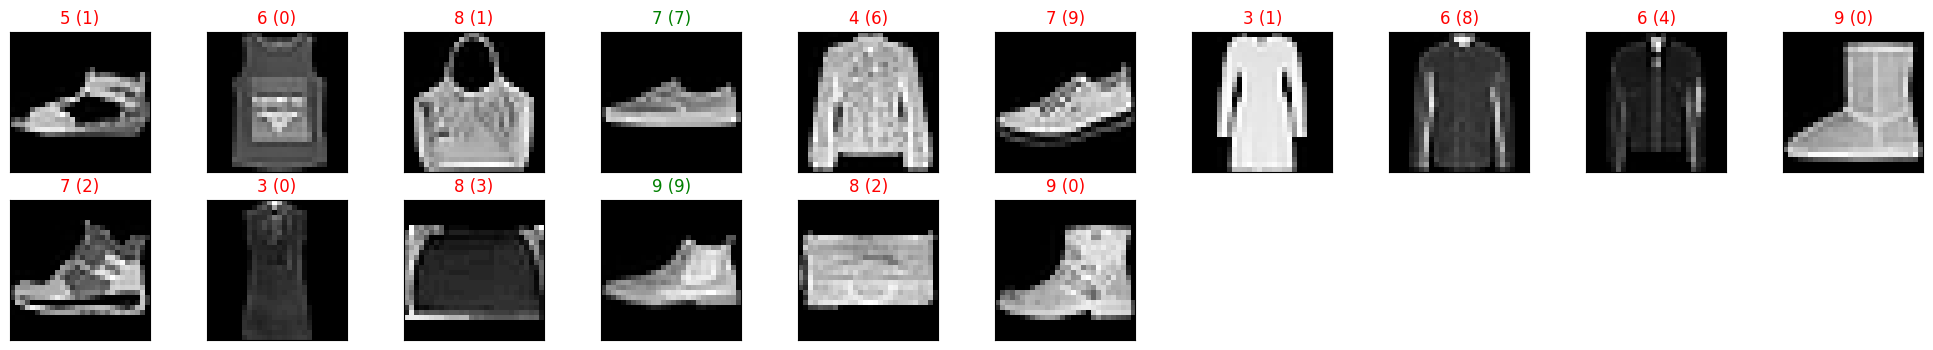

In [9]:
#obtain one batch of test images
dataiter=iter(testloader)
images,lables=next(dataiter)

#get sample outputs
output=model(images)
#convert output probabilities to predicted classes
_,preds=torch.max(output,1)
#prep images for display
images=images.numpy()

fig=plt.figure(figsize=(25,4))
for idx in np.arange(16):
  ax=fig.add_subplot(2,int(20/2),idx+1,xticks=[],yticks=[])
  ax.imshow(np.squeeze(images[idx]),cmap='gray')
  ax.set_title("{} ({})".format(str(preds[idx].item()),str(labels[idx].item())),
                color=("green" if preds[idx]==labels[idx] else "red"))